In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import KFold
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, precision_score, f1_score, recall_score)
from scipy.spatial.distance import euclidean
from joblib import Parallel, delayed
from IPython.display import clear_output

# Custom modules
import Functions.dataFrameTools as dataFrameTools
import Functions.processGen as processGen

# Model import
from parametricVAE import dVAE
from sklearn.svm import SVC


### Fetch all datasets

In [2]:
temp =pd.read_csv("../data/clip_sBIKED_reduced.csv", index_col=0)
temp.shape

(4512, 71)

In [3]:
###### Fetch all ratings across all groups ######
rated_bikes_df = pd.read_csv('ratings/combined_clean_ratings.csv')


###### Import BIKED visually reduced dataset ######

dfn = dataFrameTools.normalizeDF(0).astype('float32')
visual_df =pd.read_csv("../data/clip_sBIKED_reduced.csv", index_col=0)
columns_to_drop = [col for col in visual_df.columns if 'color' in col]
visual_df.drop(columns=columns_to_drop, inplace=True)
boolean_columns = visual_df.select_dtypes(include=['bool']).columns
visual_df[boolean_columns] = visual_df[boolean_columns].astype(int)
visual_df = visual_df.sort_index(axis=1)
visual_df = visual_df.select_dtypes(include=['number'])
constant_columns = [col for col in visual_df.columns if visual_df[col].nunique() == 1]
visual_df = visual_df.drop(columns=constant_columns)



###### Split rated bikes to usable/unusable ######

threshold_usable = 0.7
threshold_unusable = 1- threshold_usable

average_ratings = rated_bikes_df.groupby('bid')['rating'].mean()
usable_bikes = visual_df.loc[average_ratings[average_ratings >= threshold_usable].index]
unusable_bikes = visual_df.loc[average_ratings[average_ratings <= threshold_unusable].index]
meaningfull_bikes_df = pd.concat([usable_bikes, unusable_bikes])
meaningfull_bikes_df['usable'] = meaningfull_bikes_df.index.isin(usable_bikes.index).astype(int)

usable_ids = meaningfull_bikes_df[meaningfull_bikes_df['usable'] == True].index.tolist()
unusable_ids = meaningfull_bikes_df[meaningfull_bikes_df['usable'] == False].index.tolist()

usable_bikes = dfn.loc[usable_ids] 
unusable_bikes = dfn.loc[unusable_ids] 



##### Import Train and Test Sets ######

input_folder = 'datasets'

X_test = pd.read_csv(os.path.join(input_folder,'X_test.csv'), index_col=0)
y_test = pd.read_csv(os.path.join(input_folder,'y_test.csv'), index_col=0)
X_train = pd.read_csv(os.path.join(input_folder,'X_train.csv'), index_col=0)
y_train = pd.read_csv(os.path.join(input_folder,'y_train.csv'), index_col=0)

X_test_dfn = dfn.loc[X_test.index]
X_train_dfn = dfn.loc[X_train.index]

usable_bikes_train_df = X_train[y_train['usable'] == 1]
unusable_bikes_train_df = X_train[y_train['usable'] == 0]

usable_bikes_test_df = X_test[y_test['usable'] == 1]
unusable_bikes_test_df = X_test[y_test['usable'] == 0]

usable_bikes_test_dfn = dfn.loc[usable_bikes_test_df.index]
usable_bikes_train_dfn = dfn.loc[usable_bikes_train_df.index]
unusable_bikes_test_dfn = dfn.loc[unusable_bikes_test_df.index]
unusable_bikes_train_dfn = dfn.loc[unusable_bikes_train_df.index]


Loaded Imputed Dataframe in  1.3770132064819336 seconds


In [4]:
dfn.shape

(4512, 2395)

### Build VAE and get latent representations of usable/unusable bikes


In [ ]:
ddims = 2395
tuned_VAE_name = 'augmented_customVAE_best'

dataVAE_model =dVAE(ddims, 128, 0.1, 1e-3)
dataVAE_mean = dataVAE_model.build_vae_keras_model_mean()
dataVAE_mean.load_weights('model weights/dataVAE.h5')
encoder_mean =  dataVAE_mean.get_layer('encoder')
decoder_mean =  dataVAE_mean.get_layer('decoder')

tunedVAE=dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
tunedVAE.load_weights(f'model weights/{tuned_VAE_name}.h5')
tuned_decoder =  tunedVAE.get_layer('decoder')
tuned_encoder_mean =  tunedVAE.get_layer('encoder')

usable_bikes = dfn.loc[usable_ids] 
unusable_bikes = dfn.loc[unusable_ids] 
encoder = tuned_encoder_mean
decoder = tuned_decoder

latent_usable = encoder.predict(usable_bikes)
latent_unusable = encoder.predict(unusable_bikes)

latent_usable_test = encoder.predict(usable_bikes_test_dfn)
latent_usable_train = encoder.predict(usable_bikes_train_dfn)
latent_unusable_test = encoder.predict(unusable_bikes_test_dfn)
latent_unusable_train = encoder.predict(unusable_bikes_train_dfn)
clear_output(wait=False)

### Fit KDEs


In [ ]:
class LatentKDEClassifier:
    def __init__(self, bandwidt_usable:int,bandwidt_unusable:int, min_confidence_usable= None):
        self.kde_usable = KernelDensity(kernel='gaussian', bandwidth=bandwidt_usable)
        self.kde_unusable = KernelDensity(kernel='gaussian', bandwidth=bandwidt_unusable)
        self.min_confidence = min_confidence_usable

    def fit(self, latent_usable_train, latent_unusable_train):
        """
        Fit the KDE models to the usable and unusable training data.
        """
        self.kde_usable.fit(latent_usable_train)
        self.kde_unusable.fit(latent_unusable_train)

    def get_log_odds(self,latent_points) :
        return  self.kde_usable.score_samples(latent_points), self.kde_unusable.score_samples(latent_points)
                     
    def predict(self, latent_points):
        """
        Predict class labels for the given latent points.
        Returns an array of predicted labels (1 for usable, 0 for unusable).
        """
        # Ensure latent_points is a 2D array
        if latent_points.ndim == 1:
            latent_points = latent_points.reshape(1, -1)

        # Compute log densities for usable and unusable
        log_density_usable, log_density_unusable = self.get_log_odds(latent_points)
        
        print(f'log_likelihood_usable={log_density_usable}  log_likelihood_unusable= {log_density_unusable}')

        # Predict based on which log density is higher
        predictions = (log_density_usable > log_density_unusable) & (
            log_density_usable > self.min_confidence if self.min_confidence is not None else True
            ) 

        # Convert boolean array to integer array (1 for usable, 0 for unusable)
        return predictions.astype(int)
    
    def log_likelihoods(self, point):
        point = np.reshape(point, (1, -1))  # Make sure the point is in the right shape
        log_likelihood_usable = self.kde_usable.score_samples(point)
        log_likelihood_unusable = self.kde_unusable.score_samples(point)
        return log_likelihood_usable, log_likelihood_unusable

    def calculate_log_odds(self,dataset):
        log_odds = []
        for point in dataset:
            log_likelihood_usable, log_likelihood_unusable = self.log_likelihoods(point)
            log_odds_point = log_likelihood_usable - log_likelihood_unusable
            log_odds.append(log_odds_point)
        return log_odds
    
    def compute_gradient(self, point, epsilon = 1e-3):
        num_features = point.shape[0]
        gradient_usable = np.zeros(num_features)
        gradient_unusable = np.zeros(num_features)
        
        for i in range(num_features):
            # Perturb the point slightly in positive and negative direction
            point_plus = np.copy(point)
            point_minus = np.copy(point)
            point_plus[i] += epsilon
            point_minus[i] -= epsilon
            
            # Compute log-likelihoods for perturbed points
            log_likelihood_usable_plus, log_likelihood_unusable_plus = self.log_likelihoods(point_plus)
            log_likelihood_usable_minus, log_likelihood_unusable_minus = self.log_likelihoods(point_minus)
            
            
            # Approximate gradients
            gradient_usable[i] = (log_likelihood_usable_plus[0] - log_likelihood_usable_minus[0]) / (2 * epsilon)
            gradient_unusable[i] = (log_likelihood_unusable_plus[0] - log_likelihood_unusable_minus[0]) / (2 * epsilon)
        
        return gradient_usable, gradient_unusable


    def _get_direction(self, log_likelihood_usable,  log_likelihood_unusable,gradient_usable, gradient_unusable, use_direction = 0, alpha = 0.2):

        norm_gradient_usable = np.linalg.norm(gradient_usable)
        if norm_gradient_usable != 0: 
            gradient_usable /= norm_gradient_usable

        norm_gradient_unusable = np.linalg.norm(gradient_unusable)
        if norm_gradient_unusable != 0: 
            gradient_unusable /= norm_gradient_unusable

        if use_direction == 3:
            return gradient_usable - gradient_unusable
        elif use_direction == 1:
            return gradient_usable
        elif use_direction == 2:
            return -gradient_unusable
        elif use_direction == 5 :
            if log_likelihood_usable > log_likelihood_unusable:
                return gradient_usable - alpha*gradient_unusable
            else:
                return -gradient_unusable + alpha*gradient_usable
        elif use_direction == 4 :
            if log_likelihood_usable > log_likelihood_unusable:
                return gradient_usable 
            else:
                return -gradient_unusable
            
            


    def move_points(self, points, step_scale=0.1, use_direction = 0, alpha = 0.2):
        """
        Adjusts the given points by moving them in the direction determined by the gradients of log-likelihoods.
        
        Parameters:
            points (array-like): The input points to be adjusted.
            step_scale (float): The step size for moving the points.
            use_direction (int): Determines the strategy for combining gradients.
            alpha (float): The weight factor for balancing usable and unusable gradients.
            
        Returns:
            np.ndarray: The adjusted points.
        """
        new_points = []

        for point in points:
            current_point = np.copy(point) 
            counter = 0
            
            log_likelihood_usable, log_likelihood_unusable = self.log_likelihoods(current_point)
            print(f'step{len(new_points)} counter={counter} log_likelihood_usable={log_likelihood_usable}  log_likelihood_unusable= {log_likelihood_unusable}')

            gradient_usable, gradient_unusable = self.compute_gradient(current_point, step_scale)
            
            gradient = self._get_direction(log_likelihood_usable,  log_likelihood_unusable,gradient_usable, gradient_unusable, use_direction, alpha)

            norm = np.linalg.norm(gradient)
            if norm != 0: 
                gradient /= norm
            
            current_point += step_scale * gradient
        
            new_points.append(current_point)

                
        return np.array(new_points)



def calculate_log_likelihoods_with_cross_validation(bandwidths_usable, bandwidths_unusable, 
                                                    latent_usable_train, latent_unusable_train, 
                                                    n_splits=10):
    
    def calculate_log_odds(dataset, kde):
        log_odds = []
        for point in dataset:
            point = np.reshape(point, (1, -1))  # Ensure correct shape
            log_likelihood = kde.score_samples(point)
            log_odds.append(log_likelihood)
        return log_odds

    best_bandwidth_usable = None
    best_bandwidth_unusable = None
    best_accuracy = -np.inf
    best_preds = []
    best_y_preds = []
    for bw_usable in bandwidths_usable:
        for bw_unusable in bandwidths_unusable:

            accuracies = []
            # Define cross-validation strategy
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

            all_preds = []
            all_y_val = []

            # Cross-validation loop
            for (train_usable_idx, val_usable_idx), (train_unusable_idx, val_unusable_idx) in zip(kf.split(latent_usable_train), kf.split(latent_unusable_train)):
                # Fit the KDE models on the training data
                kde_usable = KernelDensity(kernel='gaussian', bandwidth=bw_usable)
                kde_usable.fit(latent_usable_train[train_usable_idx])
                
                kde_unusable = KernelDensity(kernel='gaussian', bandwidth=bw_unusable)
                kde_unusable.fit(latent_unusable_train[train_unusable_idx])

                # Concatenate the validation set (usable + unusable)
                val_set = np.concatenate([latent_usable_train[val_usable_idx], latent_unusable_train[val_unusable_idx]])

                # Create the corresponding labels for the validation set (1 for usable, 0 for unusable)
                y_val = np.concatenate([np.ones(len(val_usable_idx)), np.zeros(len(val_unusable_idx))])

                # Calculate log-odds for both KDEs on the validation set
                log_odds_usable = calculate_log_odds(val_set, kde_usable)
                log_odds_unusable = calculate_log_odds(val_set, kde_unusable)

                # Generate predictions based on log-odds comparison
                preds = [1 if log_odds_usable[i] > log_odds_unusable[i] else 0 
                            for i in range(len(log_odds_usable))]

                # Calculate accuracy of this fold
                accuracy = accuracy_score(y_val, preds)  # Compare predictions with true labels
                # accuracy = f1_score(y_val, preds)
                accuracies.append(accuracy)

                # Append the predictions and true labels for confusion matrix
                all_preds.extend(preds)
                all_y_val.extend(y_val)


            # Return the mean accuracy for this combination of bandwidths
            mean_accuracy =  np.mean(accuracies)

            if mean_accuracy > best_accuracy:
                best_accuracy = mean_accuracy
                best_bandwidth_usable = bw_usable
                best_bandwidth_unusable = bw_unusable
                best_preds = all_preds
                best_y_preds = all_y_val

    cm = confusion_matrix(best_y_preds, best_preds)
    # print(cm)
    ConfusionMatrixDisplay(cm, display_labels=["Unusable", "Usable"]).plot()
    report = classification_report(best_y_preds, best_preds, target_names=["Unusable", "Usable"])
    print(report)
    return best_bandwidth_usable, best_bandwidth_unusable, best_accuracy




              precision    recall  f1-score   support

    Unusable       0.81      0.41      0.55        41
      Usable       0.59      0.90      0.71        39

    accuracy                           0.65        80
   macro avg       0.70      0.66      0.63        80
weighted avg       0.70      0.65      0.63        80

Best bandwidth for usable KDE: 0.28
Best bandwidth for unusable KDE: 0.36
Best accuracy: 0.6537698412698412


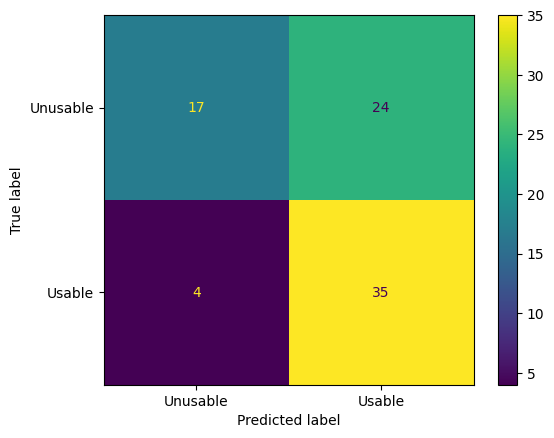

In [9]:
# Define the range of bandwidths to test for both KDEs
bandwidths_usable = [i*0.01 + 0.2 for i in range(20)]   # Bandwidths for usable KDE  0.2 - 0.4 with step 0.01
bandwidths_unusable = [i*0.01 + 0.2 for i in range(20)]  # Bandwidths for unusable KDE 0.2 - 0.4 with step 0.01

# Calculate the best bandwidths
best_bandwidth_usable, best_bandwidth_unusable, best_accuracy = calculate_log_likelihoods_with_cross_validation(
    bandwidths_usable,
    bandwidths_unusable,
    latent_usable_train,
    latent_unusable_train,
    n_splits=10
)

print("Best bandwidth for usable KDE:", best_bandwidth_usable)
print("Best bandwidth for unusable KDE:", best_bandwidth_unusable)
print("Best accuracy:", best_accuracy)

latent_kde_classifier = LatentKDEClassifier(best_bandwidth_usable, best_bandwidth_unusable)
latent_kde_classifier.fit(latent_usable_train, latent_unusable_train)


## Building SVM Classifier


In [ ]:
class SVMClassifier:
    def __init__(self, kernel='poly',C = 100, coef0 = 10, degree= 2, gamma= 'scale', scaler=1000):
        """
        Initializes the SVMClassifier with specified kernel, regularization, and scaling parameters.

        Parameters:
        - kernel (str): The kernel type to be used in the algorithm. 
                        Options include 'linear', 'poly', 'rbf', 'sigmoid', etc. (default: 'poly').
        - C (float): Regularization parameter. The strength of the regularization is inversely proportional to C. 
                     Must be a positive float (default: 100).
        - coef0 (float): Independent term in kernel function. Only significant for 'poly' and 'sigmoid' kernels (default: 10).
        - degree (int): Degree of the polynomial kernel function ('poly'). Ignored by other kernels (default: 2).
        - gamma (str or float): Kernel coefficient for 'rbf', 'poly', and 'sigmoid'. 
                                Can be 'scale', 'auto', or a positive float (default: 'scale').
        - scaler (float): A scaling factor to avoid floating point errors (default: 1000).

        Attributes:
        - model (sklearn.svm.SVC): The Support Vector Classifier instance initialized with the given parameters.
        """
        # Initialize the SVM with the given kernel, C, and degree
        self.kernel = kernel
        self.C = C
        self.degree = degree
        self.coef0 = coef0
        self.gamma = gamma

        self.svm_clf = SVC(kernel=self.kernel,C = self.C, coef0 = self.coef0, degree= self.degree, gamma=  self.gamma)

        self.scaler = scaler if not scaler is None else 1

    def fit(self, X_feature, y_train, isScaled = False):
        """
        Fit the SVM model to the training data.
        
        Parameters:
        - X_feature: array-like, shape (n_samples, n_features)
            The feature matrix for training.
        - y_train: array-like, shape (n_samples,)
            The target labels for training.
        """
        X_feature = np.array(X_feature)
        X_feature = X_feature *self.scaler if not isScaled else X_feature
        # Fit the model to the data
        self.svm_clf.fit(X_feature, y_train)

    def predict(self, points, isScaled = False):
        """
        Predict the labels of the given latent points using the trained SVM model.
        
        Parameters:
        - latent_points: array-like, shape (n_samples, n_features)
            The points to be classified.
            
        Returns:
        - predictions: array, shape (n_samples,)
            Predicted class labels for the input samples.
        """
        points = np.array(points)
        points = points *self.scaler if not isScaled else points

        # Predict the class labels for the given points
        return self.svm_clf.predict(points)
    
    def distance_to_boundary(self, point, isScaled = False):
        """
        Calculate the distance of a point from the decision boundary.
        """
        point = np.array(point).reshape(1, -1)
        point = point *self.scaler if not isScaled else point

        decision_value = self.svm_clf.decision_function(point)
        
        # distance = np.abs(decision_value) / np.linalg.norm(self.svm_clf.dual_coef_)
        
        # return distance[0]
        return np.abs(decision_value[0])

    def direction_to_boundary(self, point, epsilon=1e-3,  isScaled = False):
        """
        Calculate the direction vector towards the decision boundary.
        
        Parameters:
        - point: array-like, shape (n_features,)
            The point for which to calculate the direction to the decision boundary.
        - epsilon: float, optional (default=1e-5)
            A small perturbation to approximate the gradient.
            
        Returns:
        - direction: array, shape (n_features,)
            The normalized direction vector pointing towards the decision boundary.
        """
        point = np.array(point).reshape(1, -1)

        point = point *self.scaler if not isScaled else point

        # Perturb the point slightly to calculate the numerical gradient
        perturbed_point_positive = point + epsilon
        perturbed_point_negative = point - epsilon

        # Calculate the decision function for the perturbed points
        decision_value_positive = self.svm_clf.decision_function(perturbed_point_positive)[0]
        decision_value_negative = self.svm_clf.decision_function(perturbed_point_negative)[0]

        # Approximate the gradient of the decision function using numerical differentiation
        gradient = (decision_value_positive - decision_value_negative) / (2 * epsilon)

        # Move opposite to the gradient to approach the decision boundary
        direction = -gradient  # Moving towards the decision boundary
        direction = direction / np.linalg.norm(direction)  # Normalize the direction

        return direction
    
    def plot_hyperplane_with_points(self, X_train, y_train, features,  isScaled = False,  elev=20, azim=30):
        X_train = X_train *self.scaler if not isScaled else X_train

        # Define the grid for the feature space (across all three features)
        x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
        y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
        z_min, z_max = X_train[:, 2].min() - 1, X_train[:, 2].max() + 1

        xx, yy, zz = np.meshgrid(np.linspace(x_min, x_max, 50),
                                np.linspace(y_min, y_max, 50),
                                np.linspace(z_min, z_max, 50))

        # Evaluate the decision function over the grid
        grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
        Z = self.svm_clf.decision_function(grid)
        Z = Z.reshape(xx.shape)

        tolerance = 0.1  # Adjust this value based on how strict you want to be
        boundary_points = np.abs(Z) < tolerance

        boundary_coords = grid[boundary_points.ravel()]

        # Create a 3D plot
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the decision boundary surface (where decision function ≈ 0)
        ax.scatter(boundary_coords[:, 0], boundary_coords[:, 1], boundary_coords[:, 2], 
                color='gray', marker='.', alpha=0.7, label='Decision Boundary')

        ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], X_train[y_train == 1, 2], 
                c='r', label='Usable', s=20)

        # Plot data points where y_train = 0
        ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], X_train[y_train == 0, 2], 
                c='b', label='Unusable', s=20)


        # Set labels and legend
        ax.set_xlabel(features[0])
        ax.set_ylabel(features[1])
        ax.set_zlabel(features[2])
        ax.legend()
        ax.view_init(elev=elev, azim=azim)
        # Show the plot
        plt.show()


    def move_to_closest_valid_boundary(self, point, step_size=0.01, isScaled = False):
        if isScaled:
            point = np.array(point, dtype=np.float64)
        else:
            point = np.array(point, dtype=np.float64) *self.scaler
        
        # Calculate the direction to the boundary
        direction = self.direction_to_boundary(point, isScaled=True)
        # Normalize the direction vector to unit length
        direction = direction / np.linalg.norm(direction) 
        new_point = point - step_size * direction 

        if not isScaled:
            new_point = np.array(new_point, dtype=np.float64)  / self.scaler

        return new_point

        

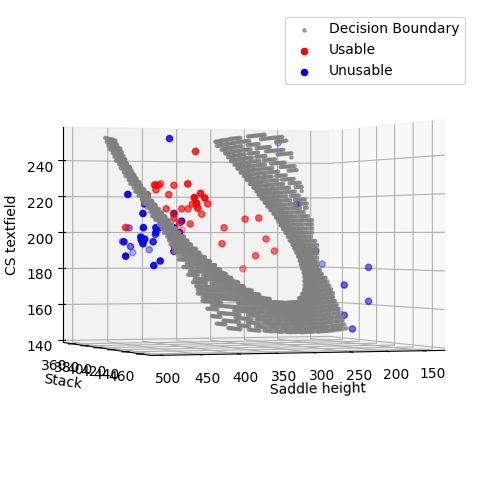

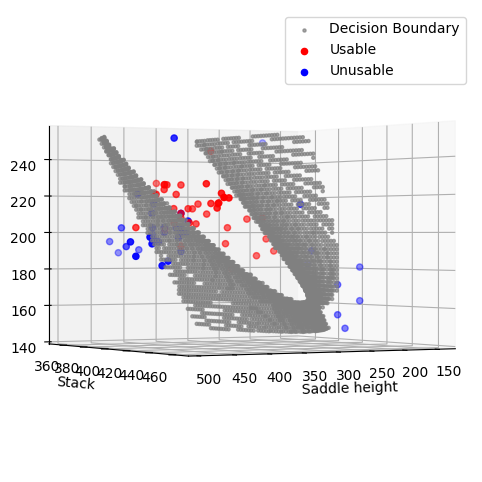

0.9


In [13]:
features = ['Saddle height', 'Stack', 'CS textfield']
# columns_to_keep =['CS textfield', 'Saddle height']
column_indices_to_keep = [unusable_bikes_train_dfn.columns.get_loc(col) for col in features]

X_feature = X_train_dfn[features].values  
y_train_series = y_train['usable']
# svm_clf = SVMClassifier(kernel='rbf', degree=2, C= 50, scaler=1000)
svm_clf = SVMClassifier(kernel='poly',C = 600, coef0 = 10, degree= 2, gamma='scale', scaler=1000)
svm_clf.fit(X_feature, y_train_series)  

svm_clf.plot_hyperplane_with_points(X_feature, y_train_series,features,elev=0, azim=70 )
svm_clf.plot_hyperplane_with_points(X_feature, y_train_series,features,elev=0, azim=60 )

y_pred = svm_clf.predict(X_feature)
print(accuracy_score(y_train_series, y_pred))



In [14]:
## Test accuracy
X_feature = X_test_dfn[features].values  
y_train_series = y_test['usable']
y_pred = svm_clf.predict(X_feature)
print(accuracy_score(y_train_series, y_pred))

0.95


### Filter poorly represented designs 


33
28
              precision    recall  f1-score   support

    Unusable       0.74      0.82      0.78        28
      Usable       0.83      0.76      0.79        33

    accuracy                           0.79        61
   macro avg       0.79      0.79      0.79        61
weighted avg       0.79      0.79      0.79        61

Best bandwidth for usable KDE: 0.28
Best bandwidth for unusable KDE: 0.25
Best accuracy: 0.7885714285714285


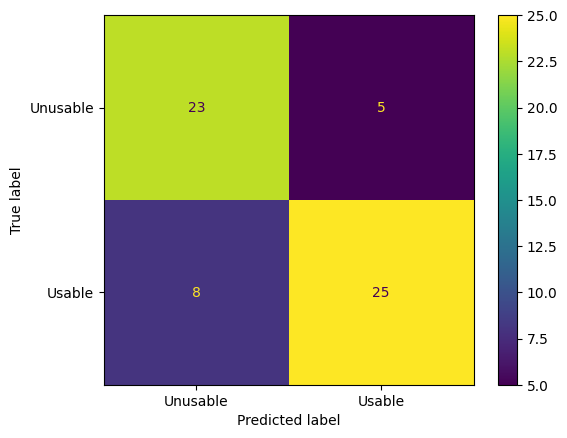

In [16]:
latent_kde_classifier = None
features = ['Saddle height', 'Stack', 'CS textfield']
column_indices_to_keep = [unusable_bikes_train_dfn.columns.get_loc(col) for col in features]

latent_unusable_train_filtered = np.empty((0, latent_usable_train.shape[1]))
unusable_bids = []
for bid in unusable_bikes_train_df.index:
    bike = unusable_bikes.loc[[bid]]
    latent = tuned_encoder_mean.predict(bike)[0]
    bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
    pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]

    if pred_svm == 0:
        latent_unusable_train_filtered = np.append(latent_unusable_train_filtered, [latent], axis=0)
        unusable_bids.append(bid)

latent_usable_train_filtered = np.empty((0, latent_usable_train.shape[1]))
usable_bids = []

for bid in usable_bikes_train_df.index:
    bike = usable_bikes.loc[[bid]]
    latent = tuned_encoder_mean.predict(bike)[0]
    bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
    pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]

    if pred_svm == 1:
        latent_usable_train_filtered = np.append(latent_usable_train_filtered, [latent], axis=0)
        usable_bids.append(bid)



clear_output(False)
print(len(latent_usable_train_filtered))
print(len(latent_unusable_train_filtered))


usable_bikes_train_filtered_dfn = usable_bikes_train_dfn.loc[usable_bids]
unusable_bikes_train_filtered_dfn = unusable_bikes_train_dfn.loc[unusable_bids]

# Define the range of bandwidths to test for both KDEs
bandwidths_usable = [i*0.01 + 0.2 for i in range(20)]   # Bandwidths for usable KDE  0.2 - 0.4 with step 0.01
bandwidths_unusable = [i*0.01 + 0.2 for i in range(20)]  # Bandwidths for unusable KDE 0.2 - 0.4 with step 0.01

# Calculate the best bandwidths
best_bandwidth_usable, best_bandwidth_unusable, best_accuracy = calculate_log_likelihoods_with_cross_validation(
    bandwidths_usable,
    bandwidths_unusable,
    latent_usable_train_filtered,
    latent_unusable_train_filtered,
)

print("Best bandwidth for usable KDE:", best_bandwidth_usable)
print("Best bandwidth for unusable KDE:", best_bandwidth_unusable)
print("Best accuracy:", best_accuracy)

latent_kde_classifier = LatentKDEClassifier(best_bandwidth_usable, best_bandwidth_unusable)
latent_kde_classifier.fit(latent_usable_train_filtered, latent_unusable_train_filtered)


### Finding best direction

In [ ]:
def initialize_models():
    # best_bandwidth_usable =  0.28
    # best_bandwidth_unusable=  0.25
    
    # Initialize and return fresh instances of the models
    # latent_kde_classifier_temp = LatentKDEClassifier(
    #     best_bandwidth_usable,
    #     best_bandwidth_unusable,
    #     min_confidence_usable=None
    # )
    # latent_kde_classifier_temp.fit(latent_usable_train_filtered, latent_unusable_train_filtered)

    latent_kde_classifier_temp = LatentKDEClassifier(best_bandwidth_usable, best_bandwidth_unusable)
    latent_kde_classifier_temp.fit(latent_usable_train_filtered, latent_unusable_train_filtered)

    tunedVAE = dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
    tunedVAE.load_weights(f'model weights/{tuned_VAE_name}.h5')
    tuned_encoder_mean = tunedVAE.get_layer('encoder')

    return latent_kde_classifier, tuned_encoder_mean

def process_pair(dir, alpha):
    try:
        # Initialize models locally to avoid pickle issues
        latent_kde_classifier_temp, tuned_encoder_mean = initialize_models()


        bikes = unusable_bikes_train_df.index
        pair_results = []
        avg_count = 0
        valid_count = 0

        for bid in bikes:
            bike = unusable_bikes.loc[[bid]]
            latent = tuned_encoder_mean.predict(bike)[0]  # Get the latent vector
            points = [latent]
            pred_kde = latent_kde_classifier_temp.predict(latent)[0]
            counter = 0

            while counter < 100 and pred_kde == 0:
                counter += 1
                new_point = latent_kde_classifier_temp.move_points([latent], step_scale=0.1, use_direction=dir, alpha=alpha)
                points.append(new_point[0])
                latent = new_point[0]
                pred_kde = latent_kde_classifier_temp.predict(latent)[0]

            if pred_kde and counter > 0:
                avg_count += counter
                valid_count += 1

        pair_results.append({
            'dir': dir,
            'alpha': alpha,
            'avg_count': avg_count / valid_count if valid_count != 0 else np.inf,
            'valid_count': valid_count
        })

        return pair_results

    except Exception as e:
        print(f"Error processing pair (dir={dir}, alpha={alpha}): {e}")
        return [f"Error processing pair (dir={dir}, alpha={alpha}): {e}"]


# Main process
if __name__ == '__main__':
    directions = [i for i in range(1,6)]

    alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
    pairs = [(direction, alpha if direction == 5 else None) for direction in directions for alpha in (alphas if direction == 5 else [None])]

    # Parallel execution with separate model initialization for each worker
    results = Parallel(n_jobs=-1)(
        delayed(process_pair)(dir, alpha) for dir, alpha in pairs
    )

    clear_output(False)
    print(results)


[[{'dir': 1, 'alpha': None, 'avg_count': 17.483870967741936, 'valid_count': 31}], [{'dir': 2, 'alpha': None, 'avg_count': 45.45161290322581, 'valid_count': 31}], [{'dir': 3, 'alpha': None, 'avg_count': 17.322580645161292, 'valid_count': 31}], [{'dir': 4, 'alpha': None, 'avg_count': 45.45161290322581, 'valid_count': 31}], [{'dir': 5, 'alpha': 0.1, 'avg_count': 30.64516129032258, 'valid_count': 31}], [{'dir': 5, 'alpha': 0.3, 'avg_count': 20.93548387096774, 'valid_count': 31}], [{'dir': 5, 'alpha': 0.5, 'avg_count': 18.387096774193548, 'valid_count': 31}], [{'dir': 5, 'alpha': 0.7, 'avg_count': 17.64516129032258, 'valid_count': 31}], [{'dir': 5, 'alpha': 0.9, 'avg_count': 17.387096774193548, 'valid_count': 31}]]


## Impact of Movements on SVM Decision Boundary Distance

### Train set

Number of bikes moved : 28


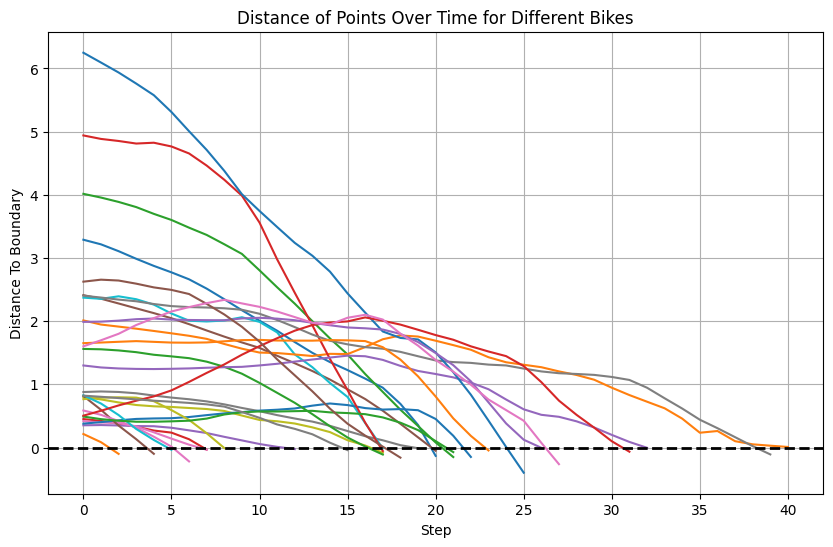

In [25]:
# latent_kde_classifier, tuned_encoder_mean = initialize_models()

bikes = unusable_bikes_train_df.index

log_usable_scores = []
log_unusable_scores = []

knn_pred = []

all_points = []

for bid in bikes:
    bike = unusable_bikes.loc[[bid]]
    latent = tuned_encoder_mean.predict(bike)[0]
    points = [latent]
    pred_svm = pred_kde = 0
    counter = 0

    bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
    pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
    pred_kde = latent_kde_classifier.predict(latent)[0]

    distances = []

    if not pred_svm:
        distances.append(svm_clf.distance_to_boundary(bike_features_point))
    else:
        distances.append(- svm_clf.distance_to_boundary(bike_features_point))

    print('svm:', 'usable' if pred_svm else 'unusable')
    print('kde:', 'usable' if pred_kde else 'unusable')
    while counter < 40 and not (pred_svm == 1):

        counter += 1

        new_point = latent_kde_classifier.move_points([latent],step_scale=0.1, use_direction=3)
        points.append(new_point[0])
        latent = new_point[0]
        
        bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
        pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
        pred_kde = latent_kde_classifier.predict(latent)[0]
        

        if not pred_svm:
            distances.append(svm_clf.distance_to_boundary(bike_features_point))
        else:
            distances.append(- svm_clf.distance_to_boundary(bike_features_point))

    if len(distances) > 1:
        all_points.append(distances)

clear_output(False)

print(f"Number of bikes moved : {len(all_points)}")

time_points = list(range(len(all_points[0])))
plt.figure(figsize=(10, 6))

for i, distances in enumerate(all_points):
    time_points = list(range(len(distances)))
    plt.plot(time_points, distances, label=f'Bike {i+1}')

plt.axhline(0, color='black', linewidth=2, linestyle='--')  

plt.xlabel('Step')
plt.ylabel('Distance To Boundary')
plt.title('Distance of Points Over Time for Different Bikes')
plt.grid(True)
plt.show()

### Test set

Number of bikes moved : 6


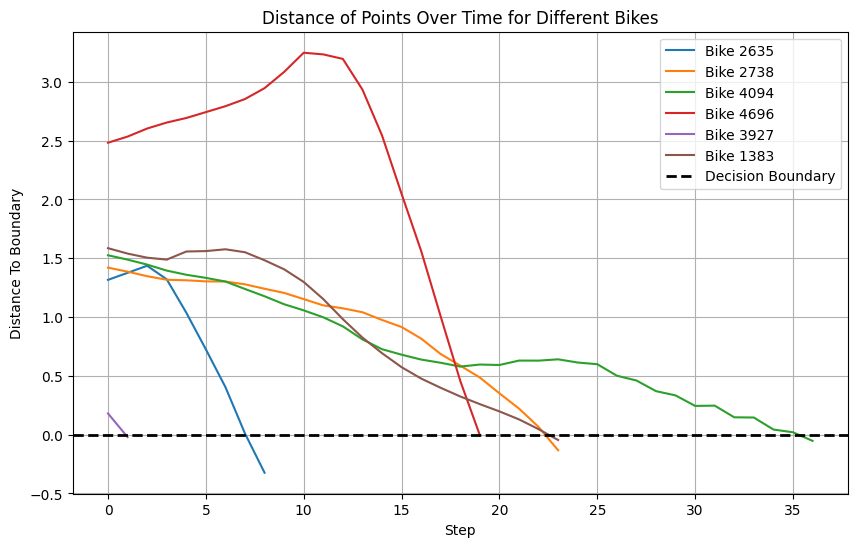

In [26]:
bikes = unusable_bikes_test_df.index

log_usable_scores = []
log_unusable_scores = []

knn_pred = []

all_points = []
bids = []
for bid in bikes:
    bike = unusable_bikes.loc[[bid]]
    latent = tuned_encoder_mean.predict(bike)[0]
    points = [latent]
    pred_svm = pred_kde = 0
    counter = 0

    bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
    pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
    pred_kde = latent_kde_classifier.predict(latent)[0]

    distances = []

    if not pred_svm:
        distances.append(svm_clf.distance_to_boundary(bike_features_point))
    else:
        distances.append(- svm_clf.distance_to_boundary(bike_features_point))

    print('svm:', 'usable' if pred_svm else 'unusable')
    print('kde:', 'usable' if pred_kde else 'unusable')
    while counter < 40 and not (pred_svm == 1):

        counter += 1

        new_point = latent_kde_classifier.move_points([latent],step_scale=0.1, use_direction=3)
        points.append(new_point[0])
        latent = new_point[0]
        
        bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
        pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
        pred_kde = latent_kde_classifier.predict(latent)[0]
        

        if not pred_svm:
            distances.append(svm_clf.distance_to_boundary(bike_features_point))
        else:
            distances.append(- svm_clf.distance_to_boundary(bike_features_point))

    if len(distances) > 1:
        bids.append(bid)
        all_points.append(distances)

clear_output(False)

print(f"Number of bikes moved : {len(all_points)}")

time_points = list(range(len(all_points[0])))
plt.figure(figsize=(10, 6))
for i, distances in enumerate(all_points):
    time_points = list(range(len(distances)))
    plt.plot(time_points, distances, label=f'Bike {bids[i]}')  # Using bid labels

# Plot a horizontal line at y=0 (SVM decision boundary)
plt.axhline(0, color='black', linewidth=2, linestyle='--', label='Decision Boundary')  

# Labeling and styling the plot
plt.xlabel('Step')
plt.ylabel('Distance To Boundary')
plt.title('Distance of Points Over Time for Different Bikes')
plt.grid(True)
plt.legend()  # Show legend with bid labels
plt.show()

## Visualization of Guiding Unusable Designs Towards Usable Regions in the Latent Space

In [ ]:
bike = unusable_bikes.loc[[1771]]

def visualise_guided_bike(kde_clf, bike):
    latent = tuned_encoder_mean.predict(bike)[0]
    points = [latent]
    pred_smv = pred_kde = 0
    counter = 0

    bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
    pred_smv = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
    pred_kde = kde_clf.predict(latent)[0]

    print(svm_clf.distance_to_boundary(bike_features_point))

    print('svm:', 'usable' if pred_smv else 'unusable')
    print('kde:', 'usable' if pred_kde else 'unusable')

    while counter < 100 and not (pred_smv == pred_kde == 1):
        counter += 1

        print(f"\n########## Start {counter} ##########")

        new_point = kde_clf.move_points([latent],step_scale=0.1, use_direction= 3)
        points.append(new_point[0])
        latent = new_point[0]
        
        bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
        pred_smv = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
        pred_kde = kde_clf.predict(latent)[0]
        
        print(svm_clf.distance_to_boundary(bike_features_point))


        print('svm:', 'usable' if pred_smv else 'unusable')
        print('kde:', 'usable' if pred_kde else 'unusable')

        print("########## End ############\n")


        
    points_tensor = tf.convert_to_tensor(points)
    res = (tf.math.sigmoid(tuned_decoder.predict(points_tensor))).numpy()
    indices = [f'{bike.index[0]}_moved_{i}' for i in range(len(points))]
    temp = pd.DataFrame(res, index=indices, columns=dfn.columns)
    temp.to_csv(f"../data/regen.csv")
    processGen.processGen("regen", denorm=True)

In [33]:
unusable_bikes_test_dfn.index.tolist()


[1246, 1771, 2635, 2087, 2738, 4094, 4696, 3927, 1383, 3012]

In [ ]:
bike = unusable_bikes.loc[[1771]]

visualise_guided_bike(latent_kde_classifier, bike)

## Minimum Confidence Threshold for the Usable Log-likelihood

### How does min confidence affect distances to regenerated bikes

In [ ]:
# Define thresholds based on mean and standard deviation of usable log-likelihood scores
mean_usable = np.mean(log_usable_scores)
std_usable = np.std(log_usable_scores)
thresholds = [
    None,
    -20,
    -10,
    0,
    10,
    20,
    30
]

# Initialize strict KDE classifiers for each threshold
kdes = []
for threshold in thresholds:
    latent_kde_classifier_strict = LatentKDEClassifier(best_bandwidth_usable, best_bandwidth_unusable, threshold)
    latent_kde_classifier_strict.fit(latent_usable_train_filtered, latent_unusable_train_filtered)
    kdes.append(latent_kde_classifier_strict)

svm_bikes = []
kde_strict_bikes = [[] for _ in thresholds]  # Separate list for each threshold
kde_strict_sign = [[] for _ in thresholds]  # Separate list for each threshold

all_bids = []
# Loop through each bike in the test set
for bid in unusable_bikes_test_dfn.index:  
    bike = unusable_bikes_test_dfn.loc[[bid]]
    latent = tuned_encoder_mean.predict(bike)[0]
    points = [latent]

    # Predict initial classification with base classifiers
    bike_parameters = tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy()
    bike_features_point = bike_parameters[0][column_indices_to_keep]
    
    # Predict with SVM and base KDE
    # pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
    preds_strict = [0 for _ in range(len(kdes))]  # Start with 0 (no classification)
    pred_svm = 0
    # Track if the bike has been added to each list
    counter = 0
    svm_count = float('inf')  # Track when SVM was first classified



    bike_features_point = bike_parameters[0][column_indices_to_keep]
    pred_svm = 1
    if pred_svm == 1:
        svm_bikes.append(bike_parameters[0])  # Add as a new row
        svm_count = counter  # Track when SVM first made its decision

    # Update each threshold-specific classifier prediction and append results if not already added
    for i, latent_kde_classifier_strict in enumerate(kdes):
        if preds_strict[i] == 0 :
            preds_strict[i] = latent_kde_classifier_strict.predict(latent)[0]
            if preds_strict[i] == 1:
                kde_strict_bikes[i].append(bike_parameters[0])  # Add as a new row
                # Track the sign based on the counter
                if counter > svm_count:
                    kde_strict_sign[i].append(1)  # Positive sign
                else:
                    kde_strict_sign[i].append(-1)  # Negative sign

    max_counter = 50
    # If the bike is not classified by SVM or KDE yet, keep iterating
    while counter < max_counter and not (pred_svm == 1 and all(pred == 1 for pred in preds_strict)):

        counter += 1

        print(f"\n########## Step {counter} ########## Bike ID: {bid} ##########")

        # Move point closer to the decision boundary
        new_point = latent_kde_classifier_strict.move_points([latent], step_scale=0.1, use_direction=3)
        latent = new_point[0]
        points.append(latent)

        # Predict updated classifications
        bike_parameters = tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy()

        
            # Append results for SVM and KDE if not yet added
        if  pred_svm == 0 :
            bike_features_point = bike_parameters[0][column_indices_to_keep]
            pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
            if pred_svm == 1:
                svm_bikes.append(bike_parameters[0])  # Add as a new row
                svm_count = counter  # Track when SVM first made its decision

        # Update each threshold-specific classifier prediction and append results if not already added
        for i, latent_kde_classifier_strict in enumerate(kdes):
            if preds_strict[i] == 0 :
                preds_strict[i] = latent_kde_classifier_strict.predict(latent)[0]
                if preds_strict[i] == 1:
                    kde_strict_bikes[i].append(bike_parameters[0])  # Add as a new row
                    # Track the sign based on the counter
                    if counter > svm_count:
                        kde_strict_sign[i].append(1)  # Positive sign
                    else:
                        kde_strict_sign[i].append(-1)  # Negative sign

    if counter == max_counter:
        for i, latent_kde_classifier_strict in enumerate(kdes):
            if preds_strict[i] == 0 :
                kde_strict_bikes[i].append(bike_parameters[0])  # Add as a new row
                # Track the sign based on the counter
                if counter > svm_count:
                    kde_strict_sign[i].append(1)  # Positive sign
                else:
                    kde_strict_sign[i].append(-1)  # Negative sign

                    
        print("########## End of Step ##########\n")

clear_output(False)

Average distance for threshold None: 2.0698
Average distance for threshold -20: 2.0698
Average distance for threshold -10: 2.1875
Average distance for threshold 0: 2.2901
Average distance for threshold 10: 2.9196
Average distance for threshold 20: 3.6389
Average distance for threshold 30: 5.6999


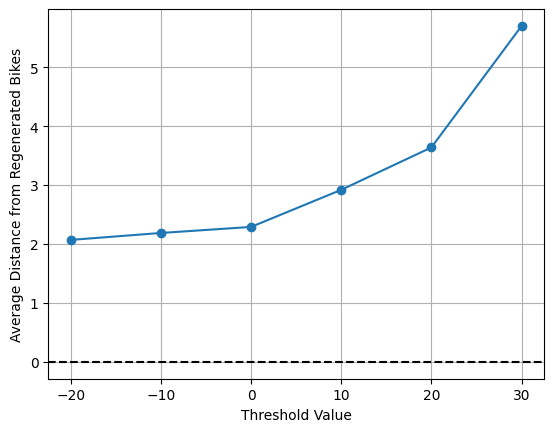

In [30]:


# Function to compute Euclidean distance between two points
def compute_avg_distance(list1, list2, sign):
    # Flatten each bike's parameters to ensure they are 1-D arrays and multiply by the sign
    return np.mean([sign[i] * euclidean(bike1.flatten(), bike2.flatten()) 
                    for i, (bike1, bike2) in enumerate(zip(list1, list2)) if sign[i] > -2])
# Initialize a list to store average distances for each threshold
avg_distances_per_threshold = []

# Loop through each threshold in kde_strict_bikes
for i, threshold_bikes in enumerate(kde_strict_bikes):
    # If there are any bikes in both svm_bikes and kde_strict_bikes for this threshold
    if svm_bikes and threshold_bikes:
        # Compute the average distance between SVM bikes and the bikes for this threshold
        avg_distance = compute_avg_distance(svm_bikes, threshold_bikes, kde_strict_sign[i]) 
        avg_distances_per_threshold.append(avg_distance)
    else:
        avg_distances_per_threshold.append(np.nan)  # If no bikes for this threshold, append NaN

# Print the results for each threshold
for i, avg_dist in enumerate(avg_distances_per_threshold):
    print(f"Average distance for threshold {thresholds[i]}: {avg_dist:.4f}")

# Optionally, if you want to plot the results
import matplotlib.pyplot as plt

plt.plot(thresholds[1:], avg_distances_per_threshold[1:], marker='o')


# # Add labels to each dot
# for i, threshold in enumerate(thresholds[1:]):
#     plt.text(threshold, avg_distances_per_threshold[i], str(threshold), ha='center', va='bottom', fontsize=9)

plt.axhline(0, color='k', linestyle='--')

# Labels and title
plt.xlabel('Threshold Value')
# plt.ylabel('Average Distance from SVM Bikes')
plt.ylabel('Average Distance from Regenerated Bikes')

# plt.title('Average Euclidean Distances for Different Thresholds')
plt.grid(True)
plt.show()

### How does min confidence affect distances to SVM bikes


In [ ]:
# Define thresholds based on mean and standard deviation of usable log-likelihood scores
mean_usable = np.mean(log_usable_scores)
std_usable = np.std(log_usable_scores)
thresholds = [
    None,
    -20,
    -10,
    0,
    10,
    20,
    30
    # mean_usable - std_usable,
    # mean_usable - 0.5 * std_usable,
    # mean_usable,
    # mean_usable + 0.5 * std_usable,
]

# Initialize strict KDE classifiers for each threshold
kdes = []
for threshold in thresholds:
    latent_kde_classifier_strict = LatentKDEClassifier(best_bandwidth_usable, best_bandwidth_unusable, threshold)
    latent_kde_classifier_strict.fit(latent_usable_train_filtered, latent_unusable_train_filtered)
    kdes.append(latent_kde_classifier_strict)

svm_bikes = []
kde_strict_bikes = [[] for _ in thresholds]  # Separate list for each threshold
kde_strict_sign = [[] for _ in thresholds]  # Separate list for each threshold

all_bids = []
# Loop through each bike in the test set
for bid in unusable_bikes_test_dfn.index:  
    bike = unusable_bikes_test_dfn.loc[[bid]]
    latent = tuned_encoder_mean.predict(bike)[0]
    points = [latent]

    # Predict initial classification with base classifiers
    bike_parameters = tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy()
    bike_features_point = bike_parameters[0][column_indices_to_keep]
    
    # Predict with SVM and base KDE
    # pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
    preds_strict = [0 for _ in range(len(kdes))]  # Start with 0 (no classification)
    pred_svm = 0
    # Track if the bike has been added to each list
    counter = 0
    svm_count = float('inf')  # Track when SVM was first classified


    # Update each threshold-specific classifier prediction and append results if not already added
    for i, latent_kde_classifier_strict in enumerate(kdes):
        if preds_strict[i] == 0 :
            preds_strict[i] = latent_kde_classifier_strict.predict(latent)[0]
            if preds_strict[i] == 1:
                kde_strict_bikes[i].append(bike_parameters[0])  # Add as a new row
                # Track the sign based on the counter
                if counter > svm_count:
                    kde_strict_sign[i].append(1)  # Positive sign
                else:
                    kde_strict_sign[i].append(-1)  # Negative sign

    max_counter = 50
    # If the bike is not classified by SVM or KDE yet, keep iterating
    while counter < max_counter and not (pred_svm == 1 and all(pred == 1 for pred in preds_strict)):

        counter += 1

        print(f"\n########## Step {counter} ########## Bike ID: {bid} ##########")

        # Move point closer to the decision boundary
        new_point = latent_kde_classifier_strict.move_points([latent], step_scale=0.1, use_direction=3)
        latent = new_point[0]
        points.append(latent)

        # Predict updated classifications
        bike_parameters = tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy()

        
            # Append results for SVM and KDE if not yet added
        if  pred_svm == 0 :
            bike_features_point = bike_parameters[0][column_indices_to_keep]
            pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
            if pred_svm == 1:
                svm_bikes.append(bike_parameters[0])  # Add as a new row
                svm_count = counter  # Track when SVM first made its decision

        # Update each threshold-specific classifier prediction and append results if not already added
        for i, latent_kde_classifier_strict in enumerate(kdes):
            if preds_strict[i] == 0 :
                preds_strict[i] = latent_kde_classifier_strict.predict(latent)[0]
                if preds_strict[i] == 1:
                    kde_strict_bikes[i].append(bike_parameters[0])  # Add as a new row
                    # Track the sign based on the counter
                    if counter > svm_count:
                        kde_strict_sign[i].append(1)  # Positive sign
                    else:
                        kde_strict_sign[i].append(-1)  # Negative sign

    if counter == max_counter:
        for i, latent_kde_classifier_strict in enumerate(kdes):
            if preds_strict[i] == 0 :
                kde_strict_bikes[i].append(bike_parameters[0])  # Add as a new row
                # Track the sign based on the counter
                if counter > svm_count:
                    kde_strict_sign[i].append(1)  # Positive sign
                else:
                    kde_strict_sign[i].append(-1)  # Negative sign

                    
        print("########## End of Step ##########\n")

clear_output(False)

Average distance for threshold None: -1.2417
Average distance for threshold -20: -1.2417
Average distance for threshold -10: -1.0821
Average distance for threshold 0: -0.6527
Average distance for threshold 10: 0.3162
Average distance for threshold 20: 1.1867
Average distance for threshold 30: 3.8601


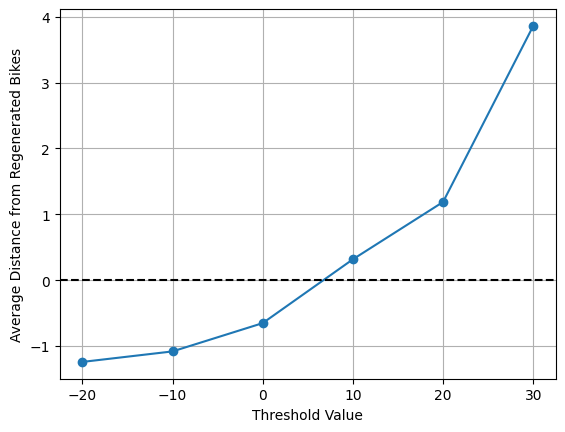

In [32]:

# Function to compute Euclidean distance between two points
def compute_avg_distance(list1, list2, sign):
    # Flatten each bike's parameters to ensure they are 1-D arrays and multiply by the sign
    return np.mean([sign[i] * euclidean(bike1.flatten(), bike2.flatten()) 
                    for i, (bike1, bike2) in enumerate(zip(list1, list2)) if sign[i] > -2])
# Initialize a list to store average distances for each threshold
avg_distances_per_threshold = []

# Loop through each threshold in kde_strict_bikes
for i, threshold_bikes in enumerate(kde_strict_bikes):
    # If there are any bikes in both svm_bikes and kde_strict_bikes for this threshold
    if svm_bikes and threshold_bikes:
        # Compute the average distance between SVM bikes and the bikes for this threshold
        avg_distance = compute_avg_distance(svm_bikes, threshold_bikes, kde_strict_sign[i]) 
        avg_distances_per_threshold.append(avg_distance)
    else:
        avg_distances_per_threshold.append(np.nan)  # If no bikes for this threshold, append NaN

# Print the results for each threshold
for i, avg_dist in enumerate(avg_distances_per_threshold):
    print(f"Average distance for threshold {thresholds[i]}: {avg_dist:.4f}")

# Optionally, if you want to plot the results
import matplotlib.pyplot as plt

plt.plot(thresholds[1:], avg_distances_per_threshold[1:], marker='o')


# # Add labels to each dot
# for i, threshold in enumerate(thresholds[1:]):
#     plt.text(threshold, avg_distances_per_threshold[i], str(threshold), ha='center', va='bottom', fontsize=9)

plt.axhline(0, color='k', linestyle='--')

# Labels and title
plt.xlabel('Threshold Value')
# plt.ylabel('Average Distance from SVM Bikes')
plt.ylabel('Average Distance from Regenerated Bikes')

# plt.title('Average Euclidean Distances for Different Thresholds')
plt.grid(True)
plt.show()

In [34]:
unusable_bikes_test_dfn.index.tolist()


[1246, 1771, 2635, 2087, 2738, 4094, 4696, 3927, 1383, 3012]

In [ ]:
latent_kde_classifier_strict = LatentKDEClassifier(best_bandwidth_usable, best_bandwidth_unusable, 20)
bike = unusable_bikes.loc[[1771]]
visualise_guided_bike(latent_kde_classifier, bike)